# 1. Problem Statement

### Data: APS Failure at Scania Trucks

- The dataset consists of data collected from heavy Scania trucks in everyday usage. The system in focus is the Air Pressure system (APS) which generates pressurised air that are utilized in various functions in a truck,such as braking and gear changes. The datasets' positive class consists of component failures for a specific component of the APS system. The negative class consists of trucks with failures for components not related to the APS. The data consists of a subset of all available data, selected by experts.
- The challenge is to reduce the overall cost of repairs, so we would have to predict the classes correctly.

### Cost Details of Faulty Prediction
- Type 1 failure-> The prediction of ours shows that there is a positive class however there was no fault.
- Type 2 failure-> The prediction of ours shows that there is a negative class when there weas an actual error in the APS system and it was supposed to be predicted positive.

Cost-metric of miss-classification:

     Predicted class |      True class       |
                     |    pos    |    neg    |
     -----------------------------------------
      pos            |     -     |  Cost_1   |
     -----------------------------------------
      neg            |  Cost_2   |     -     |
     -----------------------------------------
     Cost_1 = 10 and cost_2 = 500
     
     
- Total_cost = Cost_1*(No_Instances_of_type1_failure) + Cost_2*(No_Instances_of_type2_failure).
- The total cost of a prediction model the sum of 'Cost_1' multiplied by the number of Instances with type 1 failure and 'Cost_2' with the number of instances with type 2 failure, resulting in a 'Total_cost'.
- In this case Cost_1 refers to the cost that an unnessecary check needs to be done by an mechanic at an workshop, while Cost_2 refer to the cost of missing a faulty truck, which may cause a breakdown.

### OBJECTIVE

- **Our priority would be to reduce the false negatives since 'Cost_2=500' which is greater than 'Cost_1' and would add up for the majority of the cost, however the overall objective would be to reduce the overall cost since if the significant number of false positives also increases it can get an increase in the 'TOTAL COST'.**

## Other Challenges
- Need to Handle many Null values in almost all columns
- No low-latency requirement.
- Interpretability is not important.
- misclassification leads the unecessary repair costs.

# 2. Importing required Libraries

In [4]:
pip install catboost

     -------------------------------------- 101.0/101.0 MB 4.8 MB/s eta 0:00:00
     ---------------------------------------- 47.0/47.0 kB 1.2 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [6]:
import pandas as pd
import seaborn as sns
import numpy as np
from statistics import mean
import matplotlib.pyplot as plt
import warnings
from sklearn.preprocessing import PowerTransformer
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.utils import resample

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report,ConfusionMatrixDisplay, \
                            precision_score, recall_score, f1_score, roc_auc_score,roc_curve,confusion_matrix


from sklearn import metrics 
from sklearn.model_selection import  train_test_split, RepeatedStratifiedKFold, cross_val_score
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer, KNNImputer
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler,RobustScaler
from sklearn.compose import ColumnTransformer
from catboost import CatBoostClassifier

warnings.filterwarnings("ignore")
%matplotlib inline

### Reading the dataset

In [15]:
#Load the csv file
df = pd.read_csv("aps_failure_training_set1.csv")
df.head()

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,pos,153204,0,182,na,0,0,0,0,0,...,129862,26872,34044,22472,34362,0,0,0,0,0
1,pos,453236,na,2926,na,0,0,0,0,222,...,7908038,3026002,5025350,2025766,1160638,533834,493800,6914,0,0
2,pos,72504,na,1594,1052,0,0,0,244,178226,...,1432098,372252,527514,358274,332818,284178,3742,0,0,0
3,pos,762958,na,na,na,na,na,776,281128,2186308,...,na,na,na,na,na,na,na,na,na,na
4,pos,695994,na,na,na,na,na,0,0,0,...,1397742,495544,361646,28610,5130,212,0,0,na,na


In [16]:
#checking the rows and columns of the dataset
df.shape

(36188, 171)

In [17]:
#check the unique values of target variable
df['class'].value_counts()

neg    35188
pos     1000
Name: class, dtype: int64

In [18]:
#replacing the 'na' values with np.NAN
df.replace(to_replace='na',value=np.NAN,inplace=True)

In [19]:
#define numerical and categorical columns
cols = list(df.columns)
categorical_features=['class']
numerical_features = [col for col in cols if col !='class' ]
for i in numerical_features:
    df[i]=df[i].astype('float64')
print(f"Numerical Features length:{len(numerical_features)}")
print(f"Categorical Features length:{len(categorical_features)}")
print(df.info())

Numerical Features length:170
Categorical Features length:1
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36188 entries, 0 to 36187
Columns: 171 entries, class to eg_000
dtypes: float64(170), object(1)
memory usage: 47.2+ MB
None


### Checking out the missing values 

In [20]:
missing = df.isna().sum().div(df.shape[0]).mul(100).to_frame().sort_values(by=0, ascending = False)
# missing.values.T[0]
missing.index

Index(['br_000', 'bq_000', 'bp_000', 'ab_000', 'cr_000', 'bo_000', 'bn_000',
       'bm_000', 'bl_000', 'bk_000',
       ...
       'aq_000', 'ao_000', 'bj_000', 'by_000', 'ck_000', 'cj_000', 'ci_000',
       'bt_000', 'aa_000', 'class'],
      dtype='object', length=171)

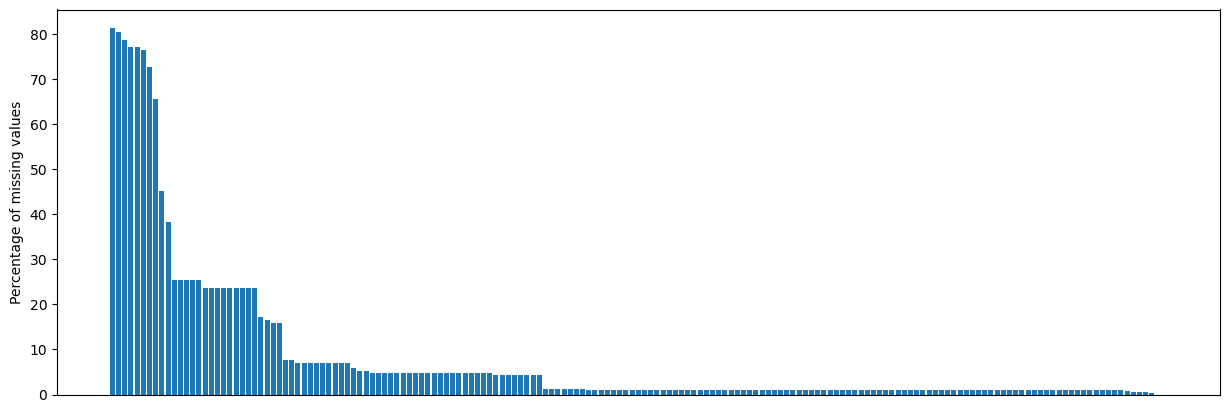

In [21]:
## Plotting Missing values count for each column 
fig ,ax = plt.subplots(figsize=(15,5))
missing = df.isna().sum().div(df.shape[0]).mul(100).to_frame().sort_values(by=0, ascending = False)
ax.bar(missing.index,missing.values.T[0])
plt.xticks([])
plt.ylabel('Percentage of missing values')
plt.show()

### Dropping column having more than 70 percentage missing values

In [22]:
dropcols = missing[missing[0]>70]
dropcols

,0
br_000,81.410965
bq_000,80.501824
bp_000,78.794075
ab_000,77.086327
cr_000,77.086327
bo_000,76.533658
bn_000,72.761689


In [23]:
df.drop(dropcols.index,axis=1,inplace=True)

In [24]:
#checking the shape of df
df.shape

(36188, 164)

In [25]:
#Checking out the total null value cells in our dataset
total_cells=np.product(df.shape)
total_missing_cells = np.sum(df.isnull().sum())
percentage_of_missing_cells = (total_missing_cells)/(total_cells)*100
print(f"The total number of missing cells in the dataframe is {percentage_of_missing_cells}%")

The total number of missing cells in the dataframe is 5.37059852747306%


### Visualization of unique values in Target column 'class'

<Axes: xlabel='class', ylabel='count'>

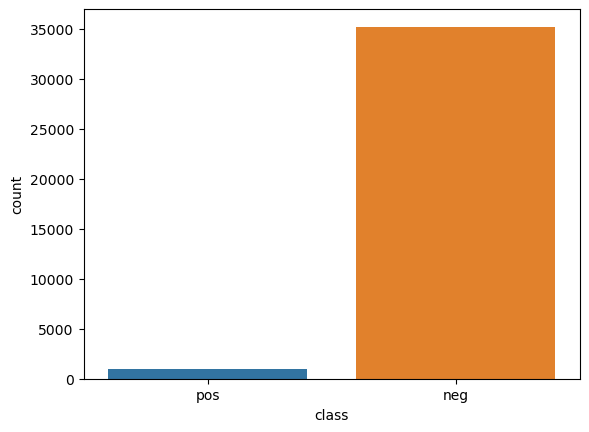

In [26]:
df['class'].value_counts()
sns.countplot(x ='class',data=df)

### Report
- The target classes are highly imbalanced
- Here the dataset is imbalanced since the the positive(minority class) is very less as compared to that of the negative class(majority) class.
- If the imbalanced data is not treated our model will not give us good accuracy. The model will be biased towards the majority class.
### Handling the imbalanced data
- Resampling is one of the technique which is used to treat imbalanced data. Two techniques used to handle the imabalanced data is:
1. Oversampling
2. Undersampling
- Here we will not perform undersampling since it will result the loss of important information.


- Besides these 2 resampling techniques we can also use hybrid techniques involving oversampling and undersampling both.
- In our projet we would be using ***SMOTE-tomek***
- This would incorporate SMOTE technique used for oversampling of minority and also the tomek technique of undersampling the instances that are tomek links among the borderline instances.

## Create functions for model training and evaluation

In [27]:
def evaluate_clf(true,predicted):
    '''
    This function takes in true , predicted values
    Returns:Accuracy,F1-score,Precision,Recall,ROC-AUC Score
    '''
    acc = accuracy_score(true,predicted)#Calculate accuracy
    f1 = f1_score(true,predicted) #Calculate f1 score
    precision = precision_score(true,predicted) #Calculate Precision
    recall = recall_score(true,predicted)#Calculate recall
    roc_auc = roc_auc_score(true,predicted)#Calculate ROC
    return acc,f1,precision,recall,roc_auc
    

In [28]:
#Get the cost of the model as per the model 
def total_cost(true,predicted):
    '''
    This function takes true and predicted values and provides us the total cost
    '''
    tn,fp,fn,tp = confusion_matrix(true,predicted).ravel()
    total_cost = 10*fp + 500*fn
    return total_cost

In [29]:
#Create a function which will evaluate models and return a report
def evaluate_models(X,y,models):
    '''
    This function takes in X as input features and y as output features. Then the data is split
    into train, test data. 
    Returns:
    '''
    #separate dataset into train and test dataset
    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)
    
    cost_list=[]
    models_list=[]
    accuracy_list=[]
    
    for i in range(len(list(models))):
        model =list(models.values())[i]
        model.fit(X_train,y_train) #Train model
        
        #make predictions
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)
        
        #Training data evaluation metrics 
        model_train_accuracy,model_train_f1,model_train_precision,\
        model_train_recall,model_train_rocauc_score = evaluate_clf(y_train,y_train_pred)
        train_cost = total_cost(y_train,y_train_pred)
        
        #Testing data evaluation metrics
        model_test_accuracy,model_test_f1,model_test_precision,\
        model_test_recall,model_test_rocauc_score = evaluate_clf(y_test,y_test_pred)
        test_cost = total_cost(y_test,y_test_pred)
        
        print(list(models.keys())[i])
        models_list.append(list(models.keys())[i])
        
        print('Model performance for Training set')
        print("-Accuracy:{:.4f}".format(model_train_accuracy))
        print('- F1 score: {:.4f}'.format(model_train_f1)) 
        print('- Precision: {:.4f}'.format(model_train_precision))
        print('- Recall: {:.4f}'.format(model_train_recall))
        print('- Roc Auc Score: {:.4f}'.format(model_train_rocauc_score))
        print(f'- COST: {train_cost}.')
        
        print('----------------------------------')
        
        print('Model performance for Test set')
        print('- Accuracy: {:.4f}'.format(model_test_accuracy))
        print('- F1 score: {:.4f}'.format(model_test_f1))
        print('- Precision: {:.4f}'.format(model_test_precision))
        print('- Recall: {:.4f}'.format(model_test_recall))
        print('- Roc Auc Score: {:.4f}'.format(model_test_rocauc_score))
        print(f'- COST: {test_cost}.')
        
        cost_list.append(test_cost)
        print('='*35)
        print('\n')
        
    report = pd.DataFrame(list(zip(models_list,cost_list)),columns = ['Models Name','Cost']).sort_values(by=['Cost'])
    return report

### Plot distribution of all independent variables 

In [30]:
#getting a new list of numerical feautures
num_features=list()
for i in numerical_features:
    if i not in dropcols.index:
        num_features.append(i)

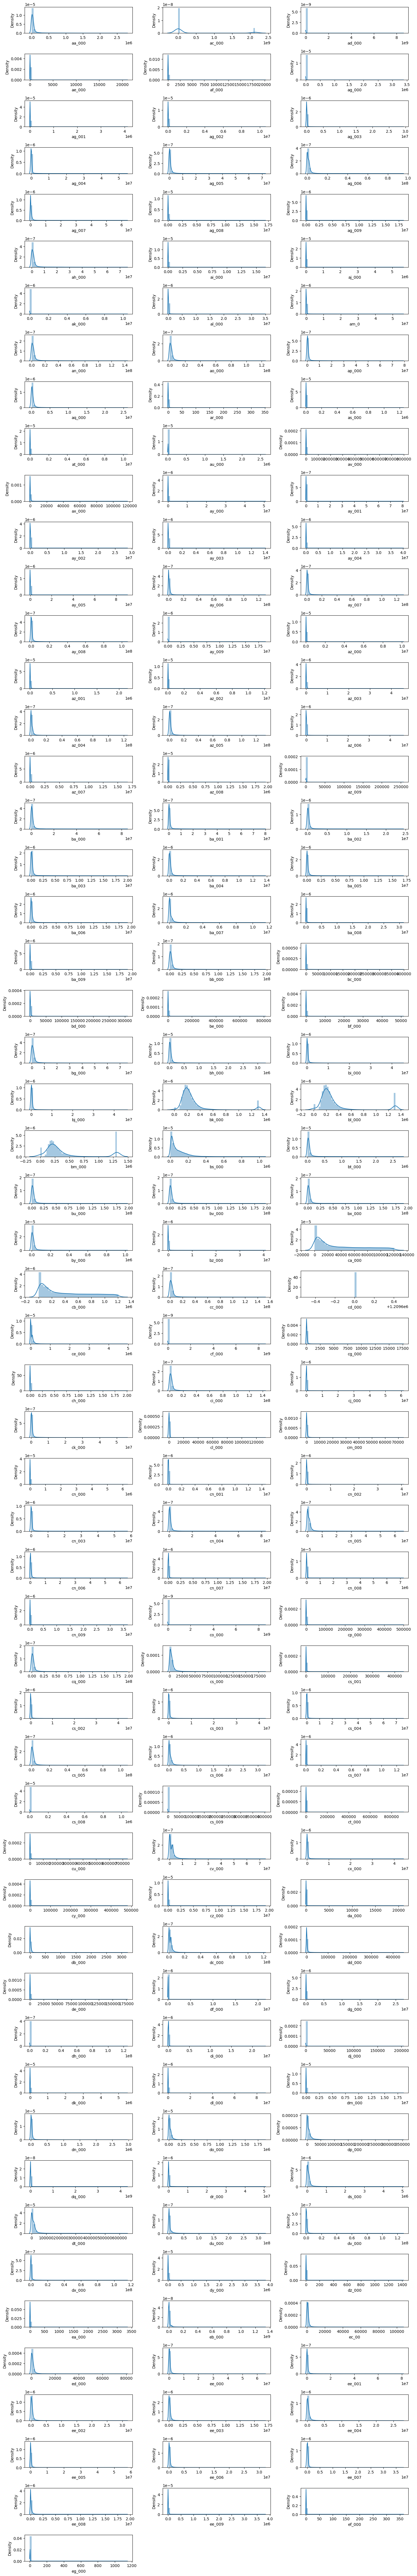

In [226]:
plt.figure(figsize =(15,100))
for i,col in enumerate(num_features):
    plt.subplot(60,3,i+1)
    sns.distplot(df[col],label=col)
    plt.tight_layout()

### Report:
- As per the plot most of the features are not normally distributed

### Evaluate model on  different experiments

In [31]:
# Splitting X and y for all Experiments
X = df.drop('class',axis=1)
y = df['class']

### Manually encoding target variable

In [32]:
y = y.replace({'pos':1,'neg':0})

# Experiment:1 - KNN Imputer for Null values

### Scaling using Robust Scaler
- We will use Robust Scaler since the data has outliers and RobustScaler is robust or strong to outliers.

In [229]:
 #Fitting data on RobustScaler
robustscaler= RobustScaler()
X1 = robustscaler.fit_transform(X)

### Why KNN imputer?
- KNNImputer by scikit-learn is a widely used method to impute missing values. It is widely being observed as a replacement for traditional imputation techniques.
- KNNImputer helps to impute missing values present in the observations by finding the nearest neighbors with the Euclidean distance matrix.
- Here we Iterate through different K values and get accuracy and choose best K values.

### Finding the optimal K value for KNN imputer

In [231]:
results = []
#define imputer
imputer = KNNImputer(n_neighbors=5,weights ='uniform',metric = 'nan_euclidean')
strategies = [str(i) for i in [1,3,5,7,9]]
for s in strategies:
    pipeline = Pipeline(steps=[('i',KNNImputer(n_neighbors=int(s))),('m',LogisticRegression())])
    scores= cross_val_score(pipeline,X1,y,scoring = 'accuracy',cv=2,n_jobs=-1)
    results.append(scores)
    print('n_neighbors=%s || accuracy (%.4f)' % (s,mean(scores)))

n_neighbors=1 || accuracy (0.7327)
n_neighbors=3 || accuracy (0.7242)
n_neighbors=5 || accuracy (0.7203)
n_neighbors=7 || accuracy (0.6850)
n_neighbors=9 || accuracy (0.7244)


- We can observe n_neighbors=1 able to produce highest accuracy

### Pipeline for KNN imputer 

In [235]:
num_features1 = X.select_dtypes(exclude='object').columns
knn_pipeline =  Pipeline(steps=[
    ('imputer', KNNImputer(n_neighbors=1 )),
    ('RobustScaler',RobustScaler())
])

In [236]:
X_knn = knn_pipeline.fit_transform(X)

### Handling imbalanced data

 **SMOTE+TOMEK** is one of such a hybrid technique that aims to clean overlapping data points for each of the classes distributed in sample space.
 
 - This method combines the SMOTE ability to generate synthetic data for minority class and Tomek Links ability to remove the data that are identified as Tomek links from the majority class
 
 - To add new data of minority class
 1. Choose random data from the minority class.
 2. Calculate the distance between the random data and its k nearest neighbors.
 3. Multiply the difference with a random number between 0 and 1, then add the result to the minority class as a synthetic sample.
 4. Repeat step number 2–3 until the desired proportion of minority class is met.
 
 - To remove the tomek links of the majority class
 1. Choose random data from the majority class.
 2. If the random data’s nearest neighbor is the data from the minority class (i.e. create the Tomek Link), then remove the Tomek Link.
 
 - This is method instead of adding duplicate data it synthesises the new data based on the already avalialble classes. Hence we choose this as our imputer method for this problem.

In [238]:
from imblearn.combine import SMOTETomek

#Resampling the minority class
smt=SMOTETomek(random_state=42,sampling_strategy='minority',n_jobs=-1)
#Fit the model to generate the data
X_res,y_res = smt.fit_resample(X_knn,y)

### Initialize default models in a dictionary

In [239]:
# Dictionary which contains models for experiment
models = {
    "Random Forest": RandomForestClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "Logistic Regression": LogisticRegression(),
     "K-Neighbors Classifier": KNeighborsClassifier(),
    "XGBClassifier": XGBClassifier(), 
     "CatBoosting Classifier": CatBoostClassifier(verbose=False),
    "AdaBoost Classifier": AdaBoostClassifier()
}

### Fit KNN imputed data for models in dictionary 

In [249]:
report_knn = evaluate_models(X_res,y_res,models)

Random Forest
Model performance for Training set
-Accuracy:1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
- COST: 0.
----------------------------------
Model performance for Test set
- Accuracy: 0.9932
- F1 score: 0.9932
- Precision: 0.9892
- Recall: 0.9973
- Roc Auc Score: 0.9932
- COST: 10260.


Decision Tree
Model performance for Training set
-Accuracy:1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
- COST: 0.
----------------------------------
Model performance for Test set
- Accuracy: 0.9878
- F1 score: 0.9879
- Precision: 0.9830
- Recall: 0.9927
- Roc Auc Score: 0.9878
- COST: 26700.


Gradient Boosting
Model performance for Training set
-Accuracy:0.9840
- F1 score: 0.9841
- Precision: 0.9813
- Recall: 0.9869
- Roc Auc Score: 0.9840
- COST: 188780.
----------------------------------
Model performance for Test set
- Accuracy: 0.9825
- F1 score: 0.9825
- Precision: 0.9793
- Recall: 0.9857
- Roc Auc Score

In [250]:
report_knn

,Models Name,Cost
5,XGBClassifier,5380
6,CatBoosting Classifier,7040
0,Random Forest,10260
1,Decision Tree,26700
2,Gradient Boosting,51460
4,K-Neighbors Classifier,52820
7,AdaBoost Classifier,90650
3,Logistic Regression,326160


- In this report we can see that XGBClassifier is the best model since the cost of model is minimum.

# Experiment:2 Simple Imputer(strategy='median')
- In case of simple Imputer we can take the strategy of median since there are outliers and mean would not be appropriate to take in this scenario.

In [252]:
#fit the simple imputer with strategy=median
pipeline2= Pipeline(steps=[
    ('imputer',SimpleImputer(strategy='median')),
    ('RobustScaler',RobustScaler())
])

In [253]:
#Fit X with median_pipeline
X_simple = pipeline2.fit_transform(X)

In [254]:
#Resampling the minority class use SMOTE Tomek
smt =SMOTETomek(random_state=42,sampling_strategy='minority')
#Fit the model to generate the data
X_res,y_res = smt.fit_resample(X_simple,y)

In [255]:
#Training the model
report_simple=evaluate_models(X_res,y_res,models)

Random Forest
Model performance for Training set
-Accuracy:1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
- COST: 0.
----------------------------------
Model performance for Test set
- Accuracy: 0.9915
- F1 score: 0.9916
- Precision: 0.9863
- Recall: 0.9970
- Roc Auc Score: 0.9915
- COST: 11480.


Decision Tree
Model performance for Training set
-Accuracy:1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
- COST: 0.
----------------------------------
Model performance for Test set
- Accuracy: 0.9858
- F1 score: 0.9860
- Precision: 0.9802
- Recall: 0.9919
- Roc Auc Score: 0.9857
- COST: 29920.


Gradient Boosting
Model performance for Training set
-Accuracy:0.9840
- F1 score: 0.9840
- Precision: 0.9813
- Recall: 0.9867
- Roc Auc Score: 0.9840
- COST: 190760.
----------------------------------
Model performance for Test set
- Accuracy: 0.9810
- F1 score: 0.9812
- Precision: 0.9757
- Recall: 0.9868
- Roc Auc Score

In [256]:
report_simple

,Models Name,Cost
6,CatBoosting Classifier,5720
5,XGBClassifier,6010
0,Random Forest,11480
1,Decision Tree,29920
2,Gradient Boosting,48240
4,K-Neighbors Classifier,54430
7,AdaBoost Classifier,87120
3,Logistic Regression,318000


- As per the experiment we can see CatBoosting Classifier is the best model here with the Simple Imputer

# Experiment:3- MICE 
- MICE stands for Multivariate Imputation By Chained Equations algorithm
- This technique by which we can effortlessly impute missing values in a dataset by looking at data from other columns and trying to estimate the best prediction for each missing value.

In [258]:
!pip install miceforest

     ---------------------------------------- 58.2/58.2 kB 1.5 MB/s eta 0:00:00
     ---------------------------------------- 1.7/1.7 MB 3.4 MB/s eta 0:00:00
     ---------------------------------------- 1.3/1.3 MB 3.4 MB/s eta 0:00:00


In [259]:
import miceforest as mf

In [260]:
X_mice = X.copy()
#Creating the kernel
kernel = mf.ImputationKernel(
  X_mice,
  save_all_iterations=True,
  random_state=100
)

In [261]:
#Running the MICE algorithm for number of times
kernel.mice(3)

In [262]:
X_mice= kernel.complete_data()

In [263]:
#now fitting robustscaler on top of it
mice_pipeline = Pipeline(steps=[
    ('RobustScaler', RobustScaler())
])

In [264]:
#Fit X_mice with RobustScaler
X_mice = mice_pipeline.fit_transform(X_mice)

In [265]:
# Resampling the minority class. The strategy can be changed as required.
smt = SMOTETomek(random_state=42,sampling_strategy='minority', n_jobs=-1 )
# Fit the model to generate the data.
X_res, y_res = smt.fit_resample(X_mice, y)

In [266]:
# Training the models
report_mice = evaluate_models(X_res, y_res, models)

Random Forest
Model performance for Training set
-Accuracy:1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
- COST: 0.
----------------------------------
Model performance for Test set
- Accuracy: 0.9910
- F1 score: 0.9911
- Precision: 0.9864
- Recall: 0.9959
- Roc Auc Score: 0.9910
- COST: 15470.


Decision Tree
Model performance for Training set
-Accuracy:1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
- COST: 0.
----------------------------------
Model performance for Test set
- Accuracy: 0.9830
- F1 score: 0.9832
- Precision: 0.9799
- Recall: 0.9866
- Roc Auc Score: 0.9830
- COST: 48930.


Gradient Boosting
Model performance for Training set
-Accuracy:0.9835
- F1 score: 0.9835
- Precision: 0.9803
- Recall: 0.9867
- Roc Auc Score: 0.9835
- COST: 192060.
----------------------------------
Model performance for Test set
- Accuracy: 0.9803
- F1 score: 0.9805
- Precision: 0.9756
- Recall: 0.9854
- Roc Auc Score

In [267]:
report_mice

,Models Name,Cost
5,XGBClassifier,3030
6,CatBoosting Classifier,6650
0,Random Forest,15470
4,K-Neighbors Classifier,38290
1,Decision Tree,48930
2,Gradient Boosting,53240
7,AdaBoost Classifier,91340
3,Logistic Regression,158250


- In case of Experiment 3 XGBClassifier is the best model

# 4. Experiment - SimpleImputer(strategy=mean) 

In [328]:
pipeline3 = Pipeline(steps=[
    ('imputer',SimpleImputer(strategy='mean')),
    ('RobustScaler',RobustScaler())
])

In [329]:
X_simple2 = pipeline3.fit_transform(X)

In [330]:
smt = SMOTETomek(random_state=42,sampling_strategy='minority',n_jobs=-1)
#Resampling the minority class
X_res,y_res = smt.fit_resample(X_simple2,y)

In [331]:
#training the models
report_simple2 = evaluate_models(X_res,y_res,models)

Random Forest
Model performance for Training set
-Accuracy:1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
- COST: 0.
----------------------------------
Model performance for Test set
- Accuracy: 0.9948
- F1 score: 0.9948
- Precision: 0.9910
- Recall: 0.9986
- Roc Auc Score: 0.9948
- COST: 5630.


Decision Tree
Model performance for Training set
-Accuracy:1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
- COST: 0.
----------------------------------
Model performance for Test set
- Accuracy: 0.9865
- F1 score: 0.9864
- Precision: 0.9835
- Recall: 0.9893
- Roc Auc Score: 0.9866
- COST: 38150.


Gradient Boosting
Model performance for Training set
-Accuracy:0.9856
- F1 score: 0.9857
- Precision: 0.9828
- Recall: 0.9886
- Roc Auc Score: 0.9856
- COST: 164880.
----------------------------------
Model performance for Test set
- Accuracy: 0.9865
- F1 score: 0.9863
- Precision: 0.9835
- Recall: 0.9892
- Roc Auc Score:

In [332]:
report_simple2

,Models Name,Cost
5,XGBClassifier,1900
0,Random Forest,5630
6,CatBoosting Classifier,6990
1,Decision Tree,38150
2,Gradient Boosting,38650
4,K-Neighbors Classifier,44770
7,AdaBoost Classifier,90980
3,Logistic Regression,307240


-In this experiment 

# 5. Experiment 5 :SimpleImputer(strategy=constant) 

In [275]:
#create a pipeline with simpleimputer with strategy constant and fill value=0
pipeline4 = Pipeline(steps = [
    ('imputer',SimpleImputer(strategy = 'constant',fill_value=0)),
    ('RobustScaler',RobustScaler())
])

In [276]:
X_simple3 = pipeline4.fit_transform(X)

In [277]:
# Resampling the minority class. The strategy can be changed as required.
smt = SMOTETomek(random_state=42,sampling_strategy='minority', n_jobs=-1 )
# Fit the model to generate the data.
X_res, y_res = smt.fit_resample(X_simple3, y)

In [278]:
# training the models
report_simple3 = evaluate_models(X_res, y_res, models)

Random Forest
Model performance for Training set
-Accuracy:1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
- COST: 0.
----------------------------------
Model performance for Test set
- Accuracy: 0.9928
- F1 score: 0.9928
- Precision: 0.9887
- Recall: 0.9970
- Roc Auc Score: 0.9928
- COST: 11300.


Decision Tree
Model performance for Training set
-Accuracy:1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
- COST: 0.
----------------------------------
Model performance for Test set
- Accuracy: 0.9878
- F1 score: 0.9879
- Precision: 0.9819
- Recall: 0.9940
- Roc Auc Score: 0.9878
- COST: 22290.


Gradient Boosting
Model performance for Training set
-Accuracy:0.9830
- F1 score: 0.9830
- Precision: 0.9803
- Recall: 0.9857
- Roc Auc Score: 0.9830
- COST: 205550.
----------------------------------
Model performance for Test set
- Accuracy: 0.9805
- F1 score: 0.9807
- Precision: 0.9769
- Recall: 0.9845
- Roc Auc Score

In [279]:
report_simple3

,Models Name,Cost
5,XGBClassifier,2420
6,CatBoosting Classifier,4480
0,Random Forest,11300
1,Decision Tree,22290
4,K-Neighbors Classifier,43200
2,Gradient Boosting,56140
7,AdaBoost Classifier,98790
3,Logistic Regression,115600


- In case of Experiment 5 XGBClassifier is the best model

# 6. PCA with SimpleImputer (Constant )

- PCA is a feature elimination technique for finding out the most important features among the dataset.
- Since our dataset has 164 features we can find out the most important ones among them

In [280]:
from sklearn.decomposition import PCA

In [281]:
pca_pipeline = Pipeline(steps=[
    ('imputer',SimpleImputer(strategy='constant',fill_value=0)),
    ('RobustScaler',RobustScaler())
])

In [282]:
X_pca = pca_pipeline.fit_transform(X)

In [290]:
#Applying PCA
var_ratio = {}
for n in range(2,150):
    pc=PCA(n_components=n)
    df_pca = pc.fit(X_pca)
    var_ratio[n]=sum(df_pca.explained_variance_ratio_)

### Variance plot

<Axes: >

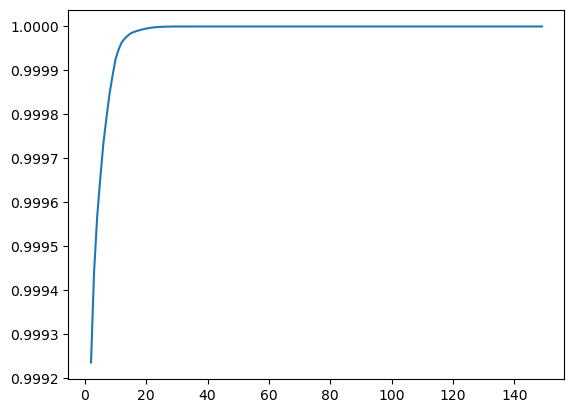

In [294]:
# plotting variance ratio
pd.Series(var_ratio).plot()

#### Kneed algorithm to find the elbow point

In [297]:
np.arange(len(var_ratio))

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147])

In [301]:
pip install kneed

Note: you may need to restart the kernel to use updated packages.


<Figure size 500x500 with 0 Axes>

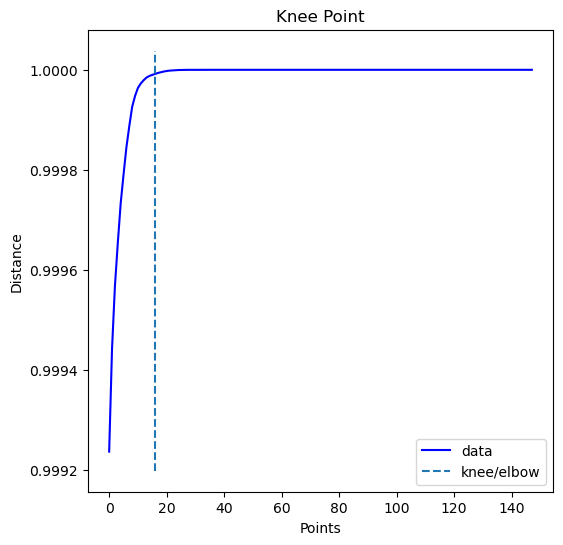

Knee Locator k= 18


In [302]:
from kneed import KneeLocator

i = np.arange(len(var_ratio))
variance_ratio = list(var_ratio.values())
components = list(var_ratio.keys())
knee = KneeLocator(i,variance_ratio,S=1, curve='concave', interp_method='polynomial')

fig = plt.figure(figsize=(5,5))
knee.plot_knee()
plt.xlabel("Points")
plt.ylabel("Distance")
plt.show()
k = components[knee.knee]
print('Knee Locator k=', k)

In [306]:
##Reducing the dimensions of the data
X_pca1 = X_pca.copy()
pca_final = PCA(n_components=18,random_state=42)
pca_final.fit_transform(X_pca1)

36188
36188


In [307]:
# Resampling the minority class. The strategy can be changed as required.
smt = SMOTETomek(random_state=42,sampling_strategy='minority', n_jobs=-1)
# Fit the model to generate the data.
X_res, y_res = smt.fit_resample(X_pca1, y)

In [308]:
# Training all models
report_pca = evaluate_models(X_res,y_res, models)

Random Forest
Model performance for Training set
-Accuracy:1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
- COST: 0.
----------------------------------
Model performance for Test set
- Accuracy: 0.9928
- F1 score: 0.9928
- Precision: 0.9887
- Recall: 0.9970
- Roc Auc Score: 0.9928
- COST: 11300.


Decision Tree
Model performance for Training set
-Accuracy:1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
- COST: 0.
----------------------------------
Model performance for Test set
- Accuracy: 0.9875
- F1 score: 0.9876
- Precision: 0.9824
- Recall: 0.9929
- Roc Auc Score: 0.9875
- COST: 26250.


Gradient Boosting
Model performance for Training set
-Accuracy:0.9830
- F1 score: 0.9830
- Precision: 0.9803
- Recall: 0.9857
- Roc Auc Score: 0.9830
- COST: 205550.
----------------------------------
Model performance for Test set
- Accuracy: 0.9807
- F1 score: 0.9808
- Precision: 0.9771
- Recall: 0.9845
- Roc Auc Score

In [309]:
report_pca

,Models Name,Cost
5,XGBClassifier,2420
6,CatBoosting Classifier,4480
0,Random Forest,11300
1,Decision Tree,26250
4,K-Neighbors Classifier,43200
2,Gradient Boosting,56120
7,AdaBoost Classifier,98790
3,Logistic Regression,115600


- In case of Experiment 6 XGBClassifier is the best classifier

# Final Model 

In [1]:
!pip install prettytable

In [5]:
from prettytable import PrettyTable

pt = PrettyTable()
pt.field_names=['Imputation Method','Model','Total Cost']
pt.add_row(['KNN Imputer ','XGBClassifier','5380'])
pt.add_row(['Simple Imputer(Median) ','CatBoosting Classifier','5720'])
pt.add_row(['MICE ','XGBClassifier','3030'])
pt.add_row(['Simple Imputer(Mean) ','XGBClassifier','1900'])
pt.add_row(['Simple Imputer(Constant) ','XGBClassifier','2420'])
pt.add_row(['Simple Imputer(Constant) with PCA ','XGBClassifier','2420'])
print(pt)

+------------------------------------+------------------------+------------+
|         Imputation Method          |         Model          | Total Cost |
+------------------------------------+------------------------+------------+
|            KNN Imputer             |     XGBClassifier      |    5380    |
|      Simple Imputer(Median)        | CatBoosting Classifier |    5720    |
|               MICE                 |     XGBClassifier      |    3030    |
|       Simple Imputer(Mean)         |     XGBClassifier      |    1900    |
|     Simple Imputer(Constant)       |     XGBClassifier      |    2420    |
| Simple Imputer(Constant) with PCA  |     XGBClassifier      |    2420    |
+------------------------------------+------------------------+------------+


### Report
- Here in the final report we can see that `Imputation Method-Simple Imputer(Mean)`, `Model - XGBClassifier` ,`Total Cost - 1900` is the best model.

### Fitting the final model and getting the report

In [34]:
from imblearn.combine import SMOTETomek
model =XGBClassifier()
pipeline = Pipeline(steps=[
    ('imputer',SimpleImputer(strategy='mean')),
    ('scaler',RobustScaler())
])
X_final = pipeline.fit_transform(X)

# Resampling the minority class. The strategy can be changed as required.
smt = SMOTETomek(random_state=42,sampling_strategy='minority', n_jobs=-1)
# Fit the model to generate the data.
X_res, y_res = smt.fit_resample(X_final, y)

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X_res,y_res,test_size=0.2,random_state=42)

final_model = model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [37]:
print("Final XGBoost Classifier Accuracy Score (Train) :", final_model.score(X_train,y_train))
print("Final XGBoost Classifier Accuracy Score (Test) :", accuracy_score(y_pred,y_test))

Final XGBoost Classifier Accuracy Score (Train) : 0.9999821810406272
Final XGBoost Classifier Accuracy Score (Test) : 0.9969351389878831


In [38]:
print("Final XGBoost Classifier Cost Metric(Test) :",total_cost(y_test, y_pred))

Final XGBoost Classifier Cost Metric(Test) : 1900


In [42]:
!pip install scikit-learn

In [52]:
from sklearn.metrics import confusion_matrix

#plot confusion matrix
cm  = confusion_matrix(y_test,y_pred)
tn, fp, fn, tp = cm.ravel()
print(tn,fp,fn,tp)

7058 40 3 6929


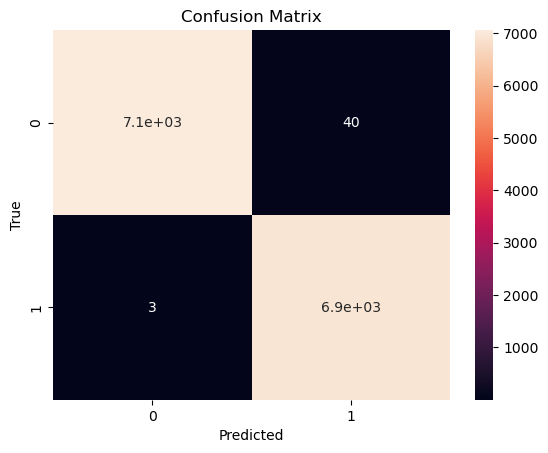

In [58]:
# Create a heatmap for better visualization
sns.heatmap(cm,annot=True)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

### Simply looking at the model we can see the total cost of the model created is 1900
 - False negative500 + Flase Poistivex10
 - Total_Cost = 3x500+40x10 = 1900